In [78]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import json

## Global Variables

In [100]:
start_year = 2013
end_year = 2024

climate_dir = "climate_timeseries"
vegetation_dir = "cluster_timeseries/classification_result"
evi = True

In [79]:
# kecamatan_names = ['warungkondang', 'cibeber', 'campaka']
kecamatan_names = ['warungkondang']
# available_climate_datasets = ['POWER_warungkondang.csv', 'POWER_cibeber.csv']
# available_climate_datasets = ['era5_warungkondang.csv', 'era5_cibeber.csv', 'era5_campaka.csv']
# available_vegetation_datasets = ['warungkondang.csv', 'cibeber3.csv', 'campaka']
available_climate_datasets = ['111']
available_vegetation_datasets = ['warungkondang.csv']

if evi:
    for i in range(len(available_vegetation_datasets)):
        available_vegetation_datasets[i] = 'evi_' + str(available_vegetation_datasets[i])

era5_features = [
        # Temperature variables
        'temperature_2m',                       # Air temperature
        'temperature_2m_min',                   # Daily minimum air temperature
        'temperature_2m_max',                   # Daily maximum air temperature
        'soil_temperature_level_1',             # Topsoil temperature (0-7 cm)
        'soil_temperature_level_2',             # Soil temperature (7-28 cm)
        
        # Moisture variables
        'volumetric_soil_water_layer_1',        # Topsoil moisture content
        'volumetric_soil_water_layer_2',        # Soil moisture (7-28 cm)
        'volumetric_soil_water_layer_3',        # Soil moisture (28-100 cm)
        'total_precipitation_sum',              # Total rainfall and snow
        'dewpoint_temperature_2m',              # Air humidity indicator
        
        # Radiation and energy variables
        'surface_solar_radiation_downwards_sum', # Solar radiation at surface
        'surface_net_solar_radiation_sum',       # Net solar radiation at surface
        
        # Evaporation and water cycle
        'total_evaporation_sum',                 # Actual evaporation
        
        # Wind variables
        'u_component_of_wind_10m',               # East-west wind component
        'v_component_of_wind_10m'                # North-south wind component
    ]

openweather_features = [
    'temp',
    'visibility',	
    'feels_like',
    'temp_min',
    'temp_max',	
    'pressure',	
    'sea_level',	
    'grnd_level',	
    'humidity',	
    'wind_speed',	
    'wind_deg', 
    'wind_gust',	
    'rain_1h',	
    'rain_3h',	
    'clouds_all'
]

extract_statistics = ['mean', 'min', 'max', 'std']
statistic_corr = ['mean', 'min', 'max', 'std', 'smoothed_mean']

## Global Functions

In [80]:
def difference_df(df):
    df = df.diff()
    return df

## Climate Datasets

In [81]:
# df_OpenWeather = pd.read_csv(f"{data_dir}/OpenWeather_pandanwangi.csv")
climate_df = {}
try:
    for i, dataset in enumerate(available_climate_datasets):
        curr = pd.read_csv(f"{climate_dir}/{dataset}")
        climate_df[kecamatan_names[i]] = curr
except:
    print(f"file kecamatan {kecamatan_names[i]} belum ada")

In [82]:
preprocessed_climate = {}
def power_climate_preprocessing(df):
    df['datetime'] = pd.to_datetime(df['YEAR'].astype(str) + 
                                  df['DOY'].astype(str), 
                                  format='%Y%j')

    df.set_index('datetime', inplace=True) # set kolom DATE sebagai index terbaru
    df = df.drop(columns=['YEAR', 'DOY'], axis=0)
    df = df.replace(-999, np.nan)
    df = df.interpolate(limit_direction='both')

    '''
    Columns description:
    T2M           MERRA-2 Temperature at 2 Meters (C)
    T2MDEW        MERRA-2 Dew/Frost Point at 2 Meters (C)
    T2MWET        MERRA-2 Wet Bulb Temperature at 2 Meters (C)
    TS            MERRA-2 Earth Skin Temperature (C)
    T2M_RANGE     MERRA-2 Temperature at 2 Meters Range (C)
    T2M_MAX       MERRA-2 Temperature at 2 Meters Maximum (C)
    T2M_MIN       MERRA-2 Temperature at 2 Meters Minimum (C)
    PS            MERRA-2 Surface Pressure (kPa)
    WS2M          MERRA-2 Wind Speed at 2 Meters (m/s)
    WS2M_MAX      MERRA-2 Wind Speed at 2 Meters Maximum (m/s)
    WS2M_MIN      MERRA-2 Wind Speed at 2 Meters Minimum (m/s)
    GWETTOP       MERRA-2 Surface Soil Wetness (1)
    GWETROOT      MERRA-2 Root Zone Soil Wetness (1)
    '''
    return df[(df.index.year >= start_year) & (df.index.year <= end_year)]

def era5_climate_preprocessing(df):
    df['datetime'] = pd.to_datetime(df['date'], format='%Y%m%d')
    df.set_index('datetime', inplace=True) # set kolom DATE sebagai index terbaru

    df = df[era5_features]
    df.interpolate(limit_direction='both')
    return df[(df.index.year >= start_year) & (df.index.year <= end_year)]

def openweather_preprocessing(df):
    

for kec in kecamatan_names:
    preprocessed_climate[kec] = era5_climate_preprocessing(climate_df[kec])

In [83]:
print(preprocessed_climate["warungkondang"].head())

            temperature_2m  temperature_2m_min  temperature_2m_max  \
datetime                                                             
2013-01-01      294.247430          292.679531          296.335467   
2013-01-02      295.012854          292.714263          298.470551   
2013-01-03      295.520867          293.294702          300.030032   
2013-01-04      294.552825          292.350513          297.182733   
2013-01-05      294.156373          292.562726          297.044142   

            soil_temperature_level_1  soil_temperature_level_2  \
datetime                                                         
2013-01-01                295.740102                296.259192   
2013-01-02                296.462650                296.402809   
2013-01-03                296.847501                296.743497   
2013-01-04                296.226519                296.517556   
2013-01-05                295.621383                296.048674   

            volumetric_soil_water_layer_1  vol

## Vegetation Datasets

In [84]:
vegetation_df = {}

try:
    for i, dataset in enumerate(available_vegetation_datasets):
        curr = pd.read_csv(f"{vegetation_dir}/{dataset}")
        vegetation_df[kecamatan_names[i]] = curr
except:
    ""

In [85]:
print(vegetation_df['warungkondang']['label'].describe())

count                 231
unique                  2
top       non-pandanwangi
freq                  184
Name: label, dtype: object


In [86]:
preprocessed_vegetation = {}

def vegetation_preprocessing(df):
    df = df.iloc[:, 1:]
    df = df[df.label == 'pandanwangi']
    df = df.set_index('cluster_id')
    df = df.describe()
    df = df.T
    df = df[extract_statistics]
    indexes = df.index
    new_indexes = []
    for i in indexes:
        date = pd.to_datetime(i, format='%Y%m%d')
        new_indexes.append(date)
    df['datetime'] = new_indexes
    df = df.set_index('datetime')
    df = df.asfreq('5D', method='nearest')

    return df[(df.index.year >= start_year) & (df.index.year <= end_year)]

for kec in kecamatan_names:
    preprocessed_vegetation[kec] = vegetation_preprocessing(vegetation_df[kec])

In [87]:
print(preprocessed_vegetation["warungkondang"])

                mean       min       max       std
datetime                                          
2013-01-05  0.413982  0.185391  0.610727  0.121054
2013-01-10  0.413982  0.185391  0.610727  0.121054
2013-01-15  0.413982  0.185391  0.610727  0.121054
2013-01-20  0.413982  0.185391  0.610727  0.121054
2013-01-25  0.413982  0.185391  0.610727  0.121054
...              ...       ...       ...       ...
2024-11-03  0.513589  0.312327  0.615076  0.085132
2024-11-08  0.459187  0.218512  0.580379  0.097760
2024-11-13  0.468430  0.218512  0.612645  0.089644
2024-11-18  0.458139  0.187469  0.669778  0.103276
2024-11-23  0.458139  0.187469  0.669778  0.103276

[869 rows x 4 columns]


In [88]:
smoothed_vegetation = {}

def smoothing_sg(df):
    filtered = savgol_filter(df['mean'], window_length=16, polyorder=4)
    df['smoothed_mean'] = filtered
    return df
    
for kec in kecamatan_names:
    smoothed_vegetation[kec] = smoothing_sg(preprocessed_vegetation[kec])

In [89]:
print(smoothed_vegetation['warungkondang'])

                mean       min       max       std  smoothed_mean
datetime                                                         
2013-01-05  0.413982  0.185391  0.610727  0.121054       0.420770
2013-01-10  0.413982  0.185391  0.610727  0.121054       0.410426
2013-01-15  0.413982  0.185391  0.610727  0.121054       0.406115
2013-01-20  0.413982  0.185391  0.610727  0.121054       0.406911
2013-01-25  0.413982  0.185391  0.610727  0.121054       0.411884
...              ...       ...       ...       ...            ...
2024-11-03  0.513589  0.312327  0.615076  0.085132       0.481139
2024-11-08  0.459187  0.218512  0.580379  0.097760       0.466773
2024-11-13  0.468430  0.218512  0.612645  0.089644       0.456220
2024-11-18  0.458139  0.187469  0.669778  0.103276       0.454082
2024-11-23  0.458139  0.187469  0.669778  0.103276       0.465846

[869 rows x 5 columns]


In [90]:
differenced_climate = {}
differenced_vegetation = {}

intersecting_indices = preprocessed_climate['warungkondang'].index.intersection(preprocessed_vegetation['warungkondang'].index)

for kec in kecamatan_names:
    differenced_climate[kec] = difference_df(preprocessed_climate[kec].loc[intersecting_indices]).iloc[1:, :]
    differenced_vegetation[kec] = difference_df(smoothed_vegetation[kec]).loc[intersecting_indices].iloc[1:, :]

In [91]:
# differenced_climate['warungkondang'].head()

In [92]:
differenced_vegetation['warungkondang'].head()

,mean,min,max,std,smoothed_mean
datetime,,,,,
2013-01-10,0.0,0.0,0.0,0.0,-0.010345
2013-01-15,0.0,0.0,0.0,0.0,-0.004310
2013-01-20,0.0,0.0,0.0,0.0,0.000796
2013-01-25,0.0,0.0,0.0,0.0,0.004973
2013-01-30,0.0,0.0,0.0,0.0,0.008223


In [93]:
# json extract
correlation_indexes = {}

for kec in kecamatan_names:
    kec_vegetation = differenced_vegetation[kec]
    kec_climate = differenced_climate[kec]
    stat_dict = {}
    for statistic in extract_statistics:
        curr_stat = kec_vegetation[statistic]
        cuaca_dict = {}
        for faktor_cuaca in era5_features:
            pearson = curr_stat.corr(kec_climate[faktor_cuaca], method='pearson')
            spearman = curr_stat.corr(kec_climate[faktor_cuaca], method='spearman')
            corr_dict = {
                'pearson': float(pearson),
                'spearman': float(pearson)
            }
            cuaca_dict[faktor_cuaca] = corr_dict
        stat_dict[statistic] = cuaca_dict
    correlation_indexes[kec] = stat_dict
            
# print(differenced_vegetation['warungkondang']['mean'].corr(differenced_climate['warungkondang']['temperature_2m'], method='pearson'))
# print(differenced_vegetation['warungkondang']['mean'].corr(differenced_climate['warungkondang']['soil_temperature_level_1'], method='pearson'))

In [94]:
# dataframe extract
correlation_indexes = {
    'kec': [],
    'statistic': [],
    'cuaca': [],
    'pearson': [],
    'spearman': []
}

for kec in kecamatan_names:
    kec_vegetation = differenced_vegetation[kec]
    kec_climate = differenced_climate[kec]
    stat_dict = {}
    for statistic in statistic_corr:
        curr_stat = kec_vegetation[statistic]
        cuaca_dict = {}
        for faktor_cuaca in era5_features:
            pearson = curr_stat.corr(kec_climate[faktor_cuaca], method='pearson')
            spearman = curr_stat.corr(kec_climate[faktor_cuaca], method='spearman')
            correlation_indexes['pearson'].append(pearson)
            correlation_indexes['spearman'].append(spearman)
            correlation_indexes['cuaca'].append(faktor_cuaca)
            correlation_indexes['statistic'].append(statistic)
            correlation_indexes['kec'].append(kec)

In [95]:
# print(json.dumps(correlation_indexes, indent=2))
correlation_df = pd.DataFrame(correlation_indexes)

In [96]:
selected_kec = 'warungkondang'
kec_corr = correlation_df[correlation_df['kec'] == selected_kec]
kec_corr.sort_values("pearson", ascending=False).head(15)

,kec,statistic,cuaca,pearson,spearman
1,warungkondang,mean,temperature_2m_min,0.203977,0.194180
9,warungkondang,mean,dewpoint_temperature_2m,0.141859,0.127872
12,warungkondang,mean,total_evaporation_sum,0.093078,0.106644
16,warungkondang,min,temperature_2m_min,0.086318,0.139262
8,warungkondang,mean,total_precipitation_sum,0.081074,0.104920
64,warungkondang,smoothed_mean,soil_temperature_level_2,0.080502,0.085696
24,warungkondang,min,dewpoint_temperature_2m,0.076006,0.129935
63,warungkondang,smoothed_mean,soil_temperature_level_1,0.059530,0.056374
58,warungkondang,std,u_component_of_wind_10m,0.054242,0.025836
19,warungkondang,min,soil_temperature_level_2,0.053590,-0.023030


In [97]:
kec_corr.sort_values("pearson", ascending=True).head(15)

,kec,statistic,cuaca,pearson,spearman
67,warungkondang,smoothed_mean,volumetric_soil_water_layer_3,-0.109689,-0.072080
11,warungkondang,mean,surface_net_solar_radiation_sum,-0.097901,-0.121154
10,warungkondang,mean,surface_solar_radiation_downwards_sum,-0.096982,-0.120637
28,warungkondang,min,u_component_of_wind_10m,-0.065007,-0.013532
30,warungkondang,max,temperature_2m,-0.064120,-0.042498
2,warungkondang,mean,temperature_2m_max,-0.061232,-0.070077
29,warungkondang,min,v_component_of_wind_10m,-0.058191,-0.069242
40,warungkondang,max,surface_solar_radiation_downwards_sum,-0.056569,-0.114289
41,warungkondang,max,surface_net_solar_radiation_sum,-0.056451,-0.114155
7,warungkondang,mean,volumetric_soil_water_layer_3,-0.055417,-0.027575


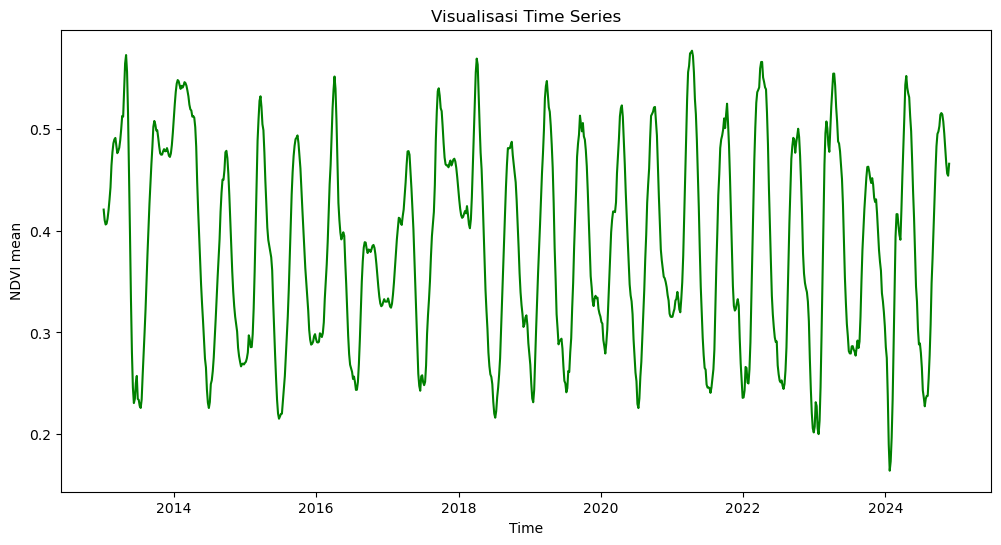

In [98]:
ts_df = preprocessed_vegetation['warungkondang']

# for stat in statistic:
plt.figure(figsize=(12, 6))
plt.plot(ts_df.index, ts_df['smoothed_mean'], label='NDVI mean', color='green')
plt.title(f'Visualisasi Time Series')
plt.xlabel('Time')
plt.ylabel('NDVI mean')
plt.show()

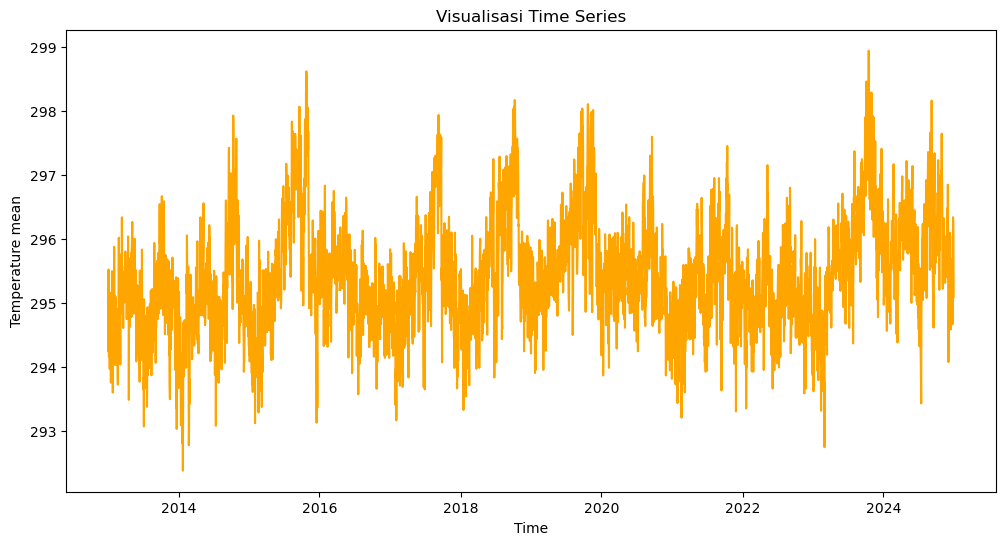

In [22]:
climate_ts = preprocessed_climate['warungkondang']

plt.figure(figsize=(12, 6))
plt.plot(climate_ts.index, climate_ts['temperature_2m'], label='temperature_2m', color='orange')
plt.title(f'Visualisasi Time Series')
plt.xlabel('Time')
plt.ylabel('Temperature mean')
plt.show()

In [41]:
diff_df

datetime
2020-01-15    0.000000
2020-01-17    0.000000
2020-01-20    0.000000
2020-01-25    0.000000
2020-03-05    0.036384
                ...   
2024-11-11   -0.048570
2024-11-14   -0.000155
2024-11-19    0.004608
2024-11-24    0.000000
2024-11-27    0.000000
Name: mean, Length: 423, dtype: float64